In [4]:

import pandas as pd
import numpy as np
train_data = pd.read_csv('C:/Users/HPS/Desktop/DM 2/734318525270241_File(new)/assignment3091251010/llm-detect-ai-generated-text/train_essays.csv')

In [5]:
len(train_data), sum(train_data['generated'])

(1378, 3)

In [6]:
train_data.head()

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


In [9]:
train_data[train_data['generated']==1]

,id,prompt_id,text,generated
704,82131f68,1,"This essay will analyze, discuss and prove one...",1
740,86fe4f18,1,I strongly believe that the Electoral College ...,1
1262,eafb8a56,0,"Limiting car use causes pollution, increases c...",1


In [12]:
train_data1 = pd.read_csv('C:/Users/HPS/Desktop/DM 2/734318525270241_File(new)/assignment3091251010/llm1.csv')

In [13]:
len(train_data1)

900

In [14]:
train_data1.head()

,Unnamed: 0,text,label
0,0,Title: The Importance and Efficiency of the El...,1
1,1,Title: The Validity and Functionality of the E...,1
2,2,Title: The Benefits of Limiting Car Usage: An ...,1
3,3,Title: The Functioning and Importance of the E...,1
4,4,Title: The Advantages of Limiting Car Usage\n\...,1


In [15]:
df1 = pd.DataFrame({'text': list(train_data['text']), 'label': list(train_data['generated'])})
df1.head()

,text,label
0,Cars. Cars have been around since they became ...,0
1,Transportation is a large necessity in most co...,0
2,"""America's love affair with it's vehicles seem...",0
3,How often do you ride in a car? Do you drive a...,0
4,Cars are a wonderful thing. They are perhaps o...,0


In [16]:
full_data = pd.concat([df1, train_data1[['text', 'label']]], axis=0)
full_data = full_data.sample(frac=1).reset_index(drop=True)
len(full_data)

2278

In [17]:
ratio = 0.75
 
total_rows = full_data.shape[0]
train_size = int(total_rows*ratio)
 
# Split data into test and train
train = full_data[0:train_size]
test = full_data[train_size:]

In [18]:
sum(test['label']), len(test['label']), sum(train['label']), len(train['label'])

(220, 570, 683, 1708)

In [19]:
def prior_prediction(label_column):
    distinct_labels = list(set(label_column))
    prob_1 = sum(label_column)/len(label_column)
    prob_0 = 1 - prob_1
    labels = {1: prob_1, 0: prob_0}
    return labels

In [20]:
import nltk, string
nltk.download('stopwords')
from nltk.corpus import stopwords
sw_nltk = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HPS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
vocab = {}
for i in range(len(train['text'])):
    word_list = []
    for word in train['text'][i].split():
        word_new  = word.strip(string.punctuation).lower()
        if (len(word_new)>2)  and (word_new not in sw_nltk): 
            vocab[word_new] = vocab.get(word_new, 0) + 1

In [22]:
features = []
cutoff_freq = 80
for key in vocab:
    if vocab[key] >=cutoff_freq:
        features.append(key)
features_dict = {}
for i, item in enumerate(features):
    features_dict[item] = i

In [23]:
X_train_dataset = np.zeros((len(train),len(features)))
# This can take some time to complete
for i in range(len(train)):
    word_list = [ word.strip(string.punctuation).lower() for word in train['text'][i].split()]
    for word in word_list:
        if word in features_dict:
            X_train_dataset[i][features_dict[word]] += 1

In [24]:
X_test_dataset = np.zeros((len(test),len(features)))
# This can take some time to complete
for i in range(len(test)):
    word_list = [ word.strip(string.punctuation).lower() for word in list(test['text'])[i].split()]
    for word in word_list:
        if word in features_dict:
            X_test_dataset[i][features_dict[word]] += 1

In [25]:
test.head()

,text,label
1708,Title: The Advantages of Limiting Car Usage\n\...,1
1709,When it comei to automobilei they can provide ...,0
1710,"Dear senator, My associates and I, have though...",0
1711,Cars are creating an harmful environment with ...,0
1712,Title: The Advantages of Limiting Car Usage\n\...,1


In [26]:
train.head()

,text,label
0,"Dear State Senator, Everyone has their very ow...",0
1,"State Senator, The Electoral College is outdat...",0
2,Title: The Benefits of Limiting Car Usage: A S...,1
3,Title: The Benefits of Limiting Car Usage\n\nA...,1
4,Title: Rethinking Car Usage: Benefits for Ours...,1


### Creating count based frequency matrix

In [27]:
word_class_dict = {}
classes = [0, 1]
word_class_dict[0] = {}
word_class_dict[1] = {}
def fill_wc_dict(word_class_dict, classes, X_train_dataset):
    for cls in classes:
        for i in range(len(X_train_dataset[0])):
            word_class_dict[cls][i] = 0
        word_class_dict[cls]['total_words'] = 0
        word_class_dict[cls]['total_essays'] = 0
    for i in range(len(X_train_dataset)):
        for j in range(len(X_train_dataset[0])):
            word_class_dict[train['label'][i]][j] += X_train_dataset[i][j]
            word_class_dict[train['label'][i]]['total_words'] += X_train_dataset[i][j]
        word_class_dict[train['label'][i]]['total_essays'] += 1
    for cls in classes:
        word_class_dict[cls]['logprob'] = np.log(word_class_dict[cls]['total_essays'])-np.log(len(X_train_dataset))
    return word_class_dict
word_class_dict = fill_wc_dict(word_class_dict, classes, X_train_dataset)

### Proability of each class given the training dataset (Prior)

In [28]:
np.exp(word_class_dict[0]['logprob']), np.exp(word_class_dict[1]['logprob'])

(0.6001170960187353, 0.39988290398126447)

### Calculate conditional probability for the given class

In [29]:
def probability(word_class_dict, test_point, cls, alpha):
    log_prob = word_class_dict[cls]['logprob']
    for i in range(len(test_point)):
        numerator = np.log(word_class_dict[cls][i]+alpha)
        denominator = np.log(word_class_dict[cls]['total_words']+alpha*len(features))
        current_word_prob = test_point[i]*(numerator-denominator)
        log_prob += current_word_prob
    return log_prob

### Compare the probability of both classes

In [30]:
def predict_best_class(test_point, alpha):
    best_class = None
    best_prob = None
    first_run = True
    log_prob_class_0 = probability(word_class_dict, test_point, 0, alpha)
    log_prob_class_1 = probability(word_class_dict, test_point, 1, alpha)
    if log_prob_class_0 > log_prob_class_1:
        best_class = 0
    else:
        best_class = 1       
    return best_class

### Inference

In [31]:
def predict(X_test, alpha):
    y_pred = [] 
    for item in X_test:
        y_pred.append(predict_best_class(item, alpha))
    return y_pred

In [32]:
def score(y_pred, y_true):
    count = 0
    for ypred, ytrue in zip(y_pred, y_true):
        count += int(ypred == ytrue)
    return count/len(y_true)

In [33]:
label_list = predict(X_test_dataset, 5000)
score(label_list, list(test['label']))

0.7807017543859649

### Hyperparameter tuning for alpha (smoothing parameter)

In [40]:
alpha = [1000000, 500000, 50000, 5000, 500, 50, 5, 1, 0.1, 0.01, 0.001, 0.0001]
accuracy = []
for item in alpha:
    label_list = predict(X_test_dataset, item)
    acc = score(label_list, list(test['label']))
    accuracy.append(acc)

In [41]:
accuracy

[0.6140350877192983,
 0.6140350877192983,
 0.6140350877192983,
 0.7807017543859649,
 0.8508771929824561,
 0.9964912280701754,
 1.0,
 0.9982456140350877,
 0.9982456140350877,
 0.9982456140350877,
 0.9982456140350877,
 0.9982456140350877]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


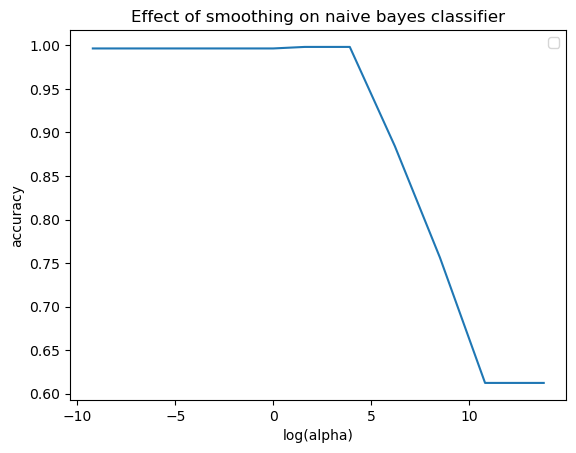

In [29]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(np.log(alpha), accuracy)
plt.xlabel('log(alpha)')
plt.ylabel('accuracy') 
plt.title('Effect of smoothing on naive bayes classifier')
plt.legend() 
plt.show()

### With the knee method, we can conclude that alpha_i = 50 is the best parameter given the dev set

In [30]:
alpha_i = 50
label_list = predict(X_test_dataset, alpha_i)
score(label_list, list(test['label']))

0.9982456140350877

In [31]:
inv_map = {v: k for k, v in features_dict.items()}

### Top 10 words class LLM generated words

In [32]:
sorted_keys = sorted(word_class_dict[1], key=word_class_dict[1].get, reverse=True)
j = 0
for r in sorted_keys:
    if r!= 'total_words' and r!='total_essays':
        print(inv_map[r], word_class_dict[1][r])
        j += 1
        if j == 10:
            break

car 1945.0
usage 1827.0
electoral 1534.0
college 1352.0
limiting 1112.0
cars 1027.0
states 1019.0
environmental 941.0
health 828.0
benefits 724.0


### Top 10 words class Human generated words

In [33]:
sorted_keys = sorted(word_class_dict[0], key=word_class_dict[0].get, reverse=True)
j = 0
for r in sorted_keys:
    if r!= 'total_words' and r!='total_essays':
        print(inv_map[r], word_class_dict[0][r])
        j += 1
        if j == 10:
            break

electoral 5550.0
people 5013.0
college 4619.0
vote 4560.0
car 4283.0
cars 4131.0
states 3150.0
would 2800.0
president 2686.0
electors 1931.0
